In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_reader import read_consumption_and_weather

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from models.cnn_model import CNNModel

import copy

from utils import *

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

df = df1

# Get the 0.9 first timesteps for training and 0.1 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

df_test = (df_test - train_mean) / train_std

df_test

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


,consumption,temperature
2022-06-26 19:00:00+00:00,-1.208172,1.267945
2022-06-26 20:00:00+00:00,-1.234116,1.173351
2022-06-26 21:00:00+00:00,-1.280757,1.112971
2022-06-26 22:00:00+00:00,-1.406576,1.054605
2022-06-26 23:00:00+00:00,-1.509782,1.016364
...,...,...
2023-01-21 19:00:00+00:00,1.457580,-2.185748
2023-01-21 20:00:00+00:00,1.397170,-2.310532
2023-01-21 21:00:00+00:00,1.301162,-2.401101
2023-01-21 22:00:00+00:00,1.233762,-2.409151


In [3]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
tw = 100
pw = 1

test_dataset = SequenceDataset(generate_cnn_sequences(df_test, tw, pw))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [4]:
# Init model and load parameters
model = CNNModel(tw=100)
model.to(device)

model.load_state_dict(torch.load('trained_models/cnn.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
criterion = nn.MSELoss()

def make_preds(model, test_loader, criterion):
    model.eval()
    predictions, actuals, test_losses = [], [], []
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            p = model(x).squeeze()
            predictions.append(p)
            actuals.append(y.squeeze())
            loss = criterion(p, y.squeeze())
            test_losses.append(loss)
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    test_loss = sum(test_losses) / len(test_losses)
    return predictions.squeeze(), actuals, test_loss

predictions, actuals, test_loss = make_preds(model, test_loader, criterion)

print(f"Final test loss: {test_loss}")

Final test loss: 0.005229884292930365


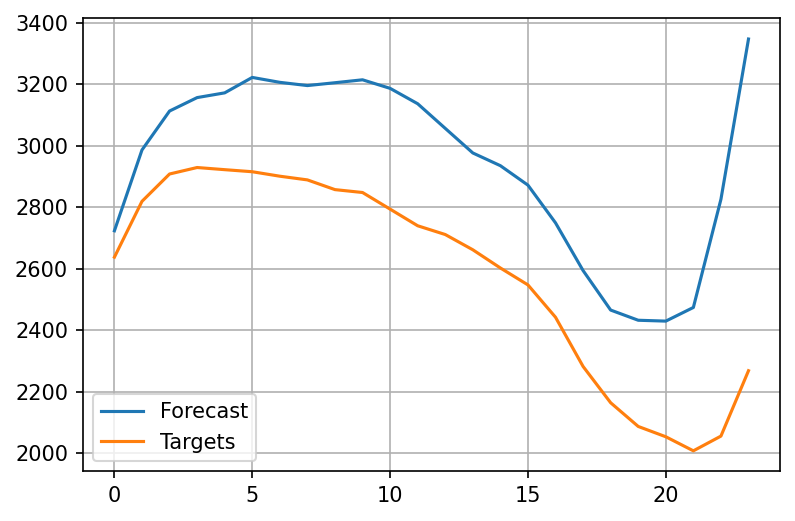

In [6]:
# Forecasting
start_point = 150
tw = 100
fw = 24

history = df_test.copy(deep=True)[start_point: start_point+tw+fw].values
targets = copy.deepcopy(history)[tw:tw+fw][:, 0]

predictions = []

# 24 timesteps into the future
for i in range(fw):
    x = history[i:tw+i].reshape(-1, 2)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    p = model(x)

    predictions.append(p.item())
    history[-fw+i, 0] = p.item()


predictions = np.array(predictions) * train_std['consumption'] + train_mean['consumption']
targets = np.array(targets) * train_std['consumption'] + train_mean['consumption']

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()